In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

import matplotlib.pylab as plt
%matplotlib inline

e:\python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
e:\python\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
dataset = pd.read_csv('../selected/train_addrank.csv')

In [3]:
target='TARGET'
IDcol = 'EID'
trainX,testX = train_test_split(dataset, test_size = 0.2,random_state=1)
train_y=trainX.TARGET
train_x=trainX.drop(['TARGET','EID'],axis=1)
val_y=testX.TARGET
val_x=testX.drop(['TARGET','EID'],axis=1)
train_y.value_counts()

0    99139
1    23265
Name: TARGET, dtype: int64

我们先定义一个函数，它可以帮助我们建立XGBoost models 并进行交叉验证。好消息是你可以直接用下面的函数，以后再自己的models中也可以使用它。

In [4]:
#test_results = pd.DataFrame(columns=['A'])  
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=train_y)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds,verbose_eval=True, show_stdv=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], train_y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(train_y, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, dtrain_predprob))
    
#     Predict on testing data:
    predicts = alg.predict_proba(dtest[predictors])[:,1]
    #results = test_results.merge(dtest[[IDcol,'predprob']], on=IDcol)
    print ('AUC Score (Test): %f' % metrics.roc_auc_score(val_y, predicts))
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[0]	train-auc:0.646354+0.00210483	test-auc:0.643427+0.00208945
[1]	train-auc:0.658891+0.00257718	test-auc:0.653075+0.00360909
[2]	train-auc:0.665421+0.0011161	test-auc:0.658484+0.00285539
[3]	train-auc:0.670981+0.00149611	test-auc:0.664046+0.00234185
[4]	train-auc:0.673804+0.00151735	test-auc:0.666448+0.00246223
[5]	train-auc:0.675835+0.00186889	test-auc:0.668247+0.00259091
[6]	train-auc:0.677427+0.00191187	test-auc:0.668979+0.00201433
[7]	train-auc:0.678731+0.00225726	test-auc:0.669521+0.00225949
[8]	train-auc:0.679884+0.00194185	test-auc:0.670903+0.00225563
[9]	train-auc:0.681394+0.00196912	test-auc:0.672488+0.00281212
[10]	train-auc:0.682632+0.00231162	test-auc:0.673183+0.00255719
[11]	train-auc:0.683952+0.00210397	test-auc:0.674517+0.00251878
[12]	train-auc:0.685165+0.00228275	test-auc:0.675918+0.00251722
[13]	train-auc:0.686563+0.00202833	test-auc:0.67687+0.00296625
[14]	train-auc:0.687885+0.00158041	test-auc:0.678098+0.00348962
[15]	train-auc:0.68933+0.00147887	test-auc:0.679366+

[128]	train-auc:0.735054+0.000990308	test-auc:0.698324+0.00478726
[129]	train-auc:0.735232+0.000977788	test-auc:0.698275+0.00481198
[130]	train-auc:0.735453+0.00103782	test-auc:0.698289+0.0048404
[131]	train-auc:0.735662+0.000929644	test-auc:0.698257+0.00483366
[132]	train-auc:0.735765+0.000934301	test-auc:0.698264+0.00483005
[133]	train-auc:0.735858+0.000925876	test-auc:0.698295+0.00489125
[134]	train-auc:0.736072+0.00101168	test-auc:0.698305+0.00489829
[135]	train-auc:0.736229+0.000990393	test-auc:0.698329+0.00490495
[136]	train-auc:0.736336+0.000960642	test-auc:0.698343+0.00491852
[137]	train-auc:0.736543+0.000987889	test-auc:0.698351+0.004988
[138]	train-auc:0.736777+0.00107919	test-auc:0.698373+0.00489358
[139]	train-auc:0.73694+0.00103475	test-auc:0.698298+0.00490568
[140]	train-auc:0.737196+0.000975318	test-auc:0.698263+0.00489328
[141]	train-auc:0.737401+0.000966068	test-auc:0.698204+0.00488025
[142]	train-auc:0.737485+0.000968819	test-auc:0.69819+0.00486268
[143]	train-auc:0.7

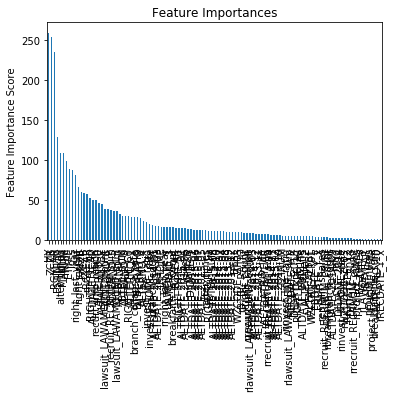

In [5]:
predictors = [x for x in train_x.columns]
xgb1 = XGBClassifier(
        learning_rate =0.2,
        n_estimators=500,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=29092.0/123914.0,
        seed=100)
modelfit(xgb1, train_x, val_x, predictors)

In [6]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':list(range(3,10,2)),
    'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.2, n_estimators=187, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=29092.0/123914.0, seed=100), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_x,train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=187, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.2347757315557564, seed=100, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [7]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.69558, std: 0.00301, params: {'min_child_weight': 1, 'max_depth': 3},
  mean: 0.69624, std: 0.00279, params: {'min_child_weight': 3, 'max_depth': 3},
  mean: 0.69646, std: 0.00254, params: {'min_child_weight': 5, 'max_depth': 3},
  mean: 0.69896, std: 0.00318, params: {'min_child_weight': 1, 'max_depth': 5},
  mean: 0.69908, std: 0.00368, params: {'min_child_weight': 3, 'max_depth': 5},
  mean: 0.69928, std: 0.00300, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: 0.69673, std: 0.00333, params: {'min_child_weight': 1, 'max_depth': 7},
  mean: 0.69856, std: 0.00318, params: {'min_child_weight': 3, 'max_depth': 7},
  mean: 0.69924, std: 0.00320, params: {'min_child_weight': 5, 'max_depth': 7},
  mean: 0.69389, std: 0.00402, params: {'min_child_weight': 1, 'max_depth': 9},
  mean: 0.69732, std: 0.00352, params: {'min_child_weight': 3, 'max_depth': 9},
  mean: 0.69765, std: 0.00296, params: {'min_child_weight': 5, 'max_depth': 9}],
 {'max_depth': 5, 'min_child_weight': 5

In [8]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.2, n_estimators=187, max_depth=5,
                                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=29092.0/123914.0, seed=100), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=2,iid=False, cv=5)
gsearch3.fit(train_x,train_y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.69928, std: 0.00300, params: {'gamma': 0.0},
  mean: 0.69936, std: 0.00333, params: {'gamma': 0.1},
  mean: 0.69936, std: 0.00306, params: {'gamma': 0.2},
  mean: 0.69981, std: 0.00305, params: {'gamma': 0.3},
  mean: 0.69923, std: 0.00312, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.6998071545434557)

[0]	train-auc:0.647447+0.000956917	test-auc:0.645541+0.00236143
[1]	train-auc:0.659243+0.0019381	test-auc:0.654634+0.00369053
[2]	train-auc:0.664978+0.000767173	test-auc:0.659742+0.00368749
[3]	train-auc:0.670657+0.00135803	test-auc:0.665582+0.00288736
[4]	train-auc:0.673164+0.000947866	test-auc:0.667294+0.00272281
[5]	train-auc:0.675138+0.00176549	test-auc:0.668905+0.00240659
[6]	train-auc:0.676468+0.00211881	test-auc:0.669533+0.00181462
[7]	train-auc:0.677913+0.00227859	test-auc:0.670408+0.00238397
[8]	train-auc:0.678917+0.0020951	test-auc:0.671602+0.00209594
[9]	train-auc:0.68056+0.00192606	test-auc:0.673228+0.00289209
[10]	train-auc:0.681762+0.0022861	test-auc:0.67408+0.00306372
[11]	train-auc:0.682902+0.00186506	test-auc:0.675343+0.00319749
[12]	train-auc:0.683972+0.00208162	test-auc:0.6763+0.00276727
[13]	train-auc:0.685418+0.00184402	test-auc:0.677284+0.00323281
[14]	train-auc:0.68674+0.00131334	test-auc:0.678613+0.0036569
[15]	train-auc:0.688269+0.00136238	test-auc:0.679957+0.0

[128]	train-auc:0.726774+0.00123037	test-auc:0.699159+0.0037024
[129]	train-auc:0.726879+0.00121092	test-auc:0.699134+0.00374338
[130]	train-auc:0.727058+0.00121578	test-auc:0.699184+0.00371192
[131]	train-auc:0.727191+0.00118644	test-auc:0.699269+0.003703
[132]	train-auc:0.727358+0.00113681	test-auc:0.699304+0.00372991
[133]	train-auc:0.727468+0.00109987	test-auc:0.699277+0.00372191
[134]	train-auc:0.72766+0.00116106	test-auc:0.699298+0.00364811
[135]	train-auc:0.727845+0.00112837	test-auc:0.69931+0.00361264
[136]	train-auc:0.727939+0.00111322	test-auc:0.699311+0.00366424
[137]	train-auc:0.72807+0.00108213	test-auc:0.699338+0.00369116
[138]	train-auc:0.728222+0.00109833	test-auc:0.699283+0.00366589
[139]	train-auc:0.728307+0.00110092	test-auc:0.699285+0.00368229
[140]	train-auc:0.728423+0.0010849	test-auc:0.699267+0.00371663
[141]	train-auc:0.728602+0.00108016	test-auc:0.699154+0.0036994
[142]	train-auc:0.728731+0.00104216	test-auc:0.699111+0.00367435
[143]	train-auc:0.728888+0.001043

[256]	train-auc:0.741879+0.00116676	test-auc:0.699714+0.00345277
[257]	train-auc:0.742018+0.00110808	test-auc:0.699737+0.00344651
[258]	train-auc:0.742111+0.00113039	test-auc:0.699817+0.00344919
[259]	train-auc:0.74222+0.00111311	test-auc:0.699705+0.00344891
[260]	train-auc:0.742279+0.00113751	test-auc:0.69971+0.00348614
[261]	train-auc:0.742397+0.00112945	test-auc:0.699666+0.00351884
[262]	train-auc:0.742459+0.00114299	test-auc:0.699621+0.00352291
[263]	train-auc:0.742572+0.00111849	test-auc:0.699616+0.00352688
[264]	train-auc:0.74269+0.00103628	test-auc:0.699629+0.00358553
[265]	train-auc:0.742795+0.00104446	test-auc:0.699613+0.00357526
[266]	train-auc:0.742893+0.00100251	test-auc:0.699556+0.00352227
[267]	train-auc:0.743122+0.00101103	test-auc:0.699603+0.00350558
[268]	train-auc:0.743187+0.000981283	test-auc:0.699611+0.00349264
[269]	train-auc:0.743328+0.00103643	test-auc:0.699625+0.00353621
[270]	train-auc:0.743436+0.00102513	test-auc:0.699611+0.00354188
[271]	train-auc:0.743498+0.

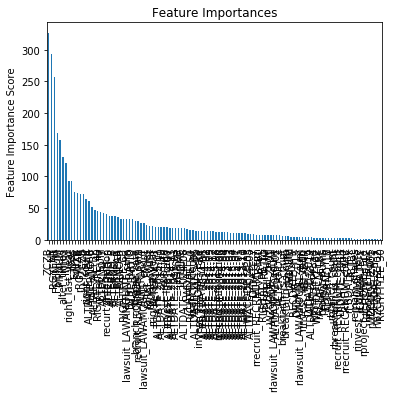

In [9]:
predictors = [x for x in train_x.columns]
xgb1 = XGBClassifier(
        learning_rate =0.2,
        n_estimators=500,
        max_depth=5,
        min_child_weight=5,
        gamma=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=2,
        scale_pos_weight=29092.0/123914.0,
        seed=100)
modelfit(xgb1, train_x, val_x, predictors)

In [10]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.2, n_estimators=277, max_depth=5,
                                        min_child_weight=5, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=29092.0/123914.0, seed=100), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_x,train_y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.69736, std: 0.00295, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.69971, std: 0.00309, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.69858, std: 0.00361, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.69965, std: 0.00334, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.69779, std: 0.00366, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.69916, std: 0.00370, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.69923, std: 0.00346, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.69996, std: 0.00283, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.69826, std: 0.00328, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.69939, std: 0.00360, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.69889, std: 0.00299, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.69949, std: 0.00298, params: {'colsample_bytree': 0.8, 'subsample'

In [11]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.2, n_estimators=277, max_depth=5,
                                        min_child_weight=5, gamma=0.3, subsample=0.7, colsample_bytree=0.9,
                                        objective= 'binary:logistic', nthread=2, scale_pos_weight=29092.0/123914.0, seed=100), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=2,iid=False, cv=5)
gsearch5.fit(train_x,train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.3, learning_rate=0.2, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=277, nthread=2,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.2347757315557564, seed=100, silent=True,
       subsample=0.7),
       fit_params={}, iid=False, n_jobs=2,
       param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9], 'subsample': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [12]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.69736, std: 0.00295, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.69971, std: 0.00309, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.69858, std: 0.00361, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.69965, std: 0.00334, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.69779, std: 0.00366, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.69916, std: 0.00370, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.69923, std: 0.00346, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.69996, std: 0.00283, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.69826, std: 0.00328, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.69939, std: 0.00360, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.69889, std: 0.00299, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.69949, std: 0.00298, params: {'subsample': 0.9, 'colsample_bytree'

In [13]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.2, n_estimators=277, max_depth=5,
                                        min_child_weight=5, gamma=0.3, subsample=0.9, colsample_bytree=0.7,
                                        objective= 'binary:logistic', nthread=2, scale_pos_weight=29092.0/123914.0, seed=100), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train_x,train_y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.69996, std: 0.00283, params: {'reg_alpha': 1e-05},
  mean: 0.70012, std: 0.00326, params: {'reg_alpha': 0.01},
  mean: 0.69994, std: 0.00352, params: {'reg_alpha': 0.1},
  mean: 0.70067, std: 0.00325, params: {'reg_alpha': 1},
  mean: 0.67211, std: 0.00209, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 0.7006669532271859)

In [15]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_lambda':[0, 50, 100, 200, 300]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.2, n_estimators=277, max_depth=5,
                                        min_child_weight=5, gamma=0.3, subsample=0.9, colsample_bytree=0.7,
                                        objective= 'binary:logistic', nthread=2, reg_alpha=1,scale_pos_weight=29092.0/123914.0, seed=100), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train_x,train_y)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.70086, std: 0.00286, params: {'reg_lambda': 0},
  mean: 0.70141, std: 0.00330, params: {'reg_lambda': 50},
  mean: 0.70097, std: 0.00280, params: {'reg_lambda': 100},
  mean: 0.69963, std: 0.00263, params: {'reg_lambda': 200},
  mean: 0.69875, std: 0.00291, params: {'reg_lambda': 300}],
 {'reg_lambda': 50},
 0.7014119180617169)